# Label Transfer of Healthy Control cell_states to query dataset control cells using scvi

In [1]:
from pathlib import Path
import scanpy as sc
import squidpy as sq
import pandas as pd
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.model.utils import mde

/home/ceger/miniforge3/envs/squidpy-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Device

In [2]:
torch.cuda.device(0)

In [3]:
if torch.cuda.is_available():
    print(f"Number of available CUDA devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA devices available")

Number of available CUDA devices: 2
Device 0: NVIDIA RTX 6000 Ada Generation
Device 1: NVIDIA RTX 6000 Ada Generation


In [4]:
device = torch.cuda.device(0)

## Data Prep

In [5]:
global_repo_data = Path.cwd() / '..' / '.data'
local_folder_data = Path.cwd() / '.data'
figures_dir = Path.cwd() / 'figures'
figures_dir.mkdir(exist_ok=True)


In [18]:
'''Labelled reference dataset'''
adata_copd = sc.read_h5ad(global_repo_data / 'Marburg_cell_states_locked_ctl240709.raw.h5ad')
adata_copd = adata_copd[adata_copd.obs['group'] == 'healthy_ctrl'].copy()
cell_states = adata_copd.obs['cell_states']
batches_copd = list(adata_copd.obs['batch'].unique())
adata_copd

AnnData object with n_obs × n_vars = 22588 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

In [7]:
'''Unlabelled query dataset'''
adata_spatial = sc.read_h5ad(local_folder_data / 'Franzen_L_2024_human.h5ad')
adata_spatial = adata_spatial[adata_spatial.obs['condition'] == 'control'].copy()
adata_spatial.obs['cell_states'] = None
adata_spatial.obs['batch'] = adata_spatial.obs['sample_id']
adata_spatial

AnnData object with n_obs × n_vars = 25116 × 27260
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'sample_name', 'slide_id', 'slide_ca', 'condition', 'subject_alias', 'tissue_alias', 'B_tissue_selection', 'fibrotic_extent_score_by_pathologist_0-3', 'replicate', 'species', 'tissue', 'subject_gender', 'n_counts', 'cell_states', 'batch'
    var: 'n_cells'
    obsm: 'spatial'

In [8]:
adata = sc.concat([adata_copd, adata_spatial])
adata.obs = adata.obs.drop('condition', axis=1)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)
adata

/home/ceger/miniforge3/envs/squidpy-env/lib/python3.11/site-packages/anndata/_core/merge.py:1284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(


AnnData object with n_obs × n_vars = 47704 × 2000
    obs: 'batch', 'n_counts', 'cell_states'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [9]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

In [10]:
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

In [11]:
scvi_model.train(devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/ceger/miniforge3/envs/squidpy-env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 168/168: 100%|██████████| 168/168 [04:52<00:00,  1.78s/it, v_num=1, train_loss_step=718, train_loss_epoch=693]

`Trainer.fit` stopped: `max_epochs=168` reached.


Epoch 168/168: 100%|██████████| 168/168 [04:52<00:00,  1.74s/it, v_num=1, train_loss_step=718, train_loss_epoch=693]


In [12]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [13]:
SCVI_MDE_KEY = "X_scVI_mde"
adata.obsm[SCVI_MDE_KEY] = mde(adata.obsm[SCVI_LATENT_KEY])

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [14]:
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.umap(adata)

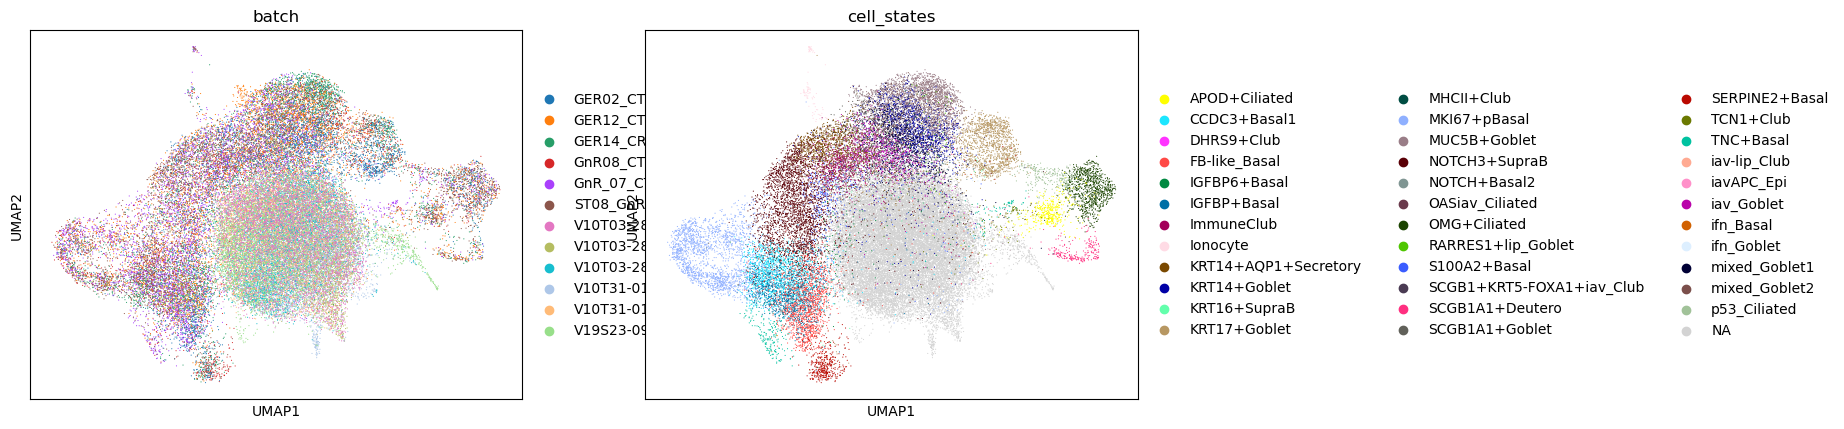

In [17]:
sc.pl.umap(adata, color=['batch', 'cell_states'])

In [35]:
SCANVI_CELLTYPE_KEY = "celltype_scanvi"

adata.obs[SCANVI_CELLTYPE_KEY] = "Unknown"
copd_mask = adata.obs["batch"].isin(batches_copd)
adata.obs['celltype_scanvi'][copd_mask] = adata.obs['cell_states'][copd_mask].values
adata.obs

/tmp/ipykernel_250862/2468900872.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['celltype_scanvi'][copd_mask] = adata.obs['cell_states'][copd_mask].values
/tmp/ipykernel_250862/2468900872.py:5: SettingWithCopyWarning: 
A value

,batch,n_counts,cell_states,_scvi_batch,_scvi_labels,celltype_scanvi
9177992-GER14_CRTL-V3,GER14_CRTL,79901.0,APOD+Ciliated,2,0,APOD+Ciliated
594856-GER14_CRTL-V3,GER14_CRTL,79493.0,SCGB1A1+Deutero,2,0,SCGB1A1+Deutero
8134752-GER14_CRTL-V3,GER14_CRTL,79422.0,APOD+Ciliated,2,0,APOD+Ciliated
8729561-GER14_CRTL-V3,GER14_CRTL,77598.0,APOD+Ciliated,2,0,APOD+Ciliated
9297458-GER14_CRTL-V3,GER14_CRTL,77172.0,SCGB1A1+Deutero,2,0,SCGB1A1+Deutero
...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1-23,V10T03-280-A1,770.0,NaN,6,0,Unknown
TTGTTTCATTAGTCTA-1-21,V10T03-280-A1,902.0,NaN,6,0,Unknown
TTGTTTCCATACAACT-1-22,V10T03-280-A1,1695.0,NaN,6,0,Unknown
TTGTTTGTATTACACG-1-12,V10T03-280-A1,692.0,NaN,6,0,Unknown


In [39]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    unlabeled_category="Unknown",
    labels_key=SCANVI_CELLTYPE_KEY,
)

/home/ceger/miniforge3/envs/squidpy-env/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 21 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/home/ceger/miniforge3/envs/squidpy-env/lib/python3.11/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 21 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [40]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ceger/miniforge3/envs/squidpy-env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [01:34<00:00,  4.66s/it, v_num=1, train_loss_step=620, train_loss_epoch=680]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it, v_num=1, train_loss_step=620, train_loss_epoch=680]


In [41]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata)

In [43]:
adata

AnnData object with n_obs × n_vars = 47704 × 2000
    obs: 'batch', 'n_counts', 'cell_states', '_scvi_batch', '_scvi_labels', 'celltype_scanvi', 'C_scANVI'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'batch_colors', 'cell_states_colors'
    obsm: 'X_scVI', 'X_scVI_mde', 'X_umap', 'X_scANVI'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [44]:
sc.pp.neighbors(adata, use_rep="X_scANVI", key_added='scANVI_neighbors')
sc.tl.umap(adata, neighbors_key='scANVI_neighbors')

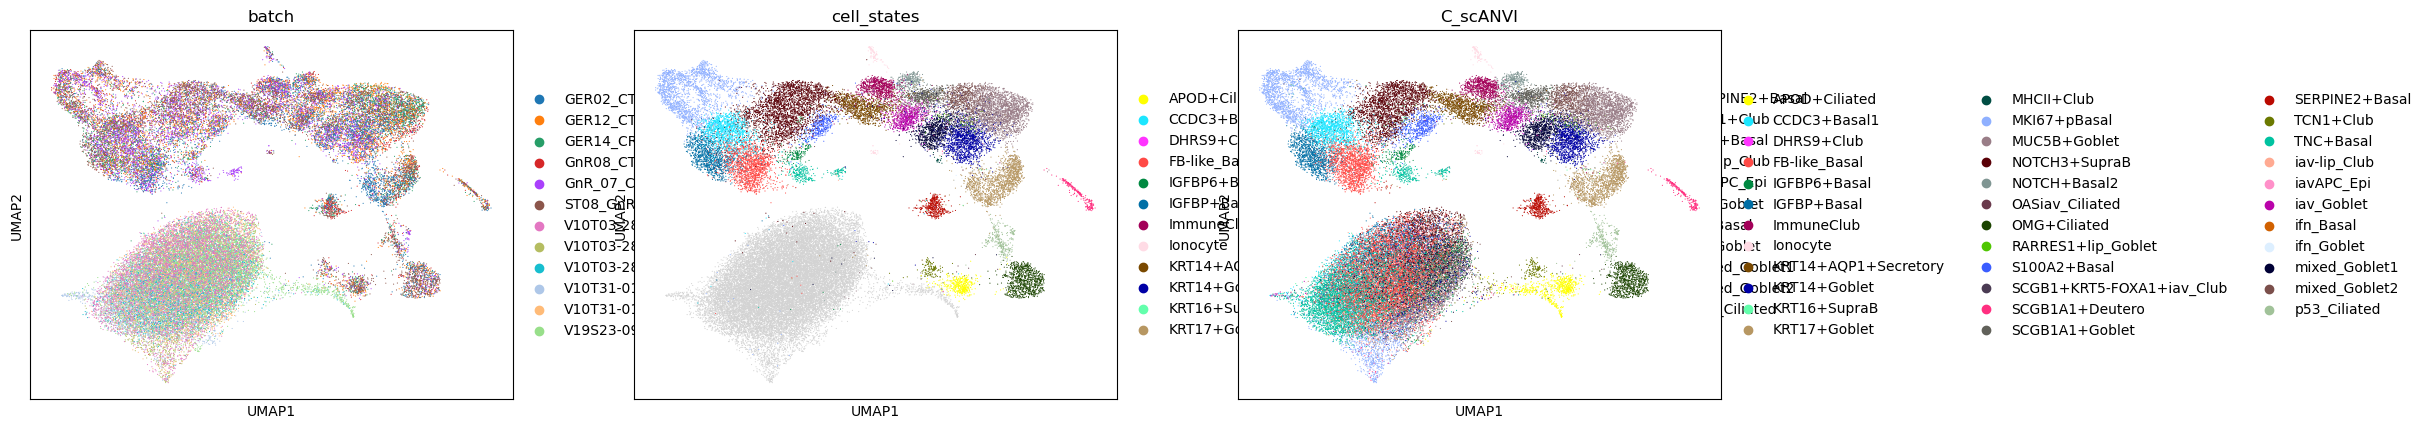

In [46]:
sc.pl.umap(adata, color=['batch', 'cell_states', 'C_scANVI'])

In [47]:
adata_file = local_folder_data / 'Franzen_L_2024_human_control_scANVI-LT.h5ad'
adata.write_h5ad(adata_file)

In [54]:
label_transfer_csv = local_folder_data / 'Franzen_L_2024_human_control_scANVI-LT_obs.csv'
adata.obs[~copd_mask].to_csv(label_transfer_csv)